# Slow Fusion

This script takes all frames at once and passes them through a cnn.

In [26]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import initializers
import time
import numpy as np

## 1. Load Data

To begin, data for a middle frames model must be loaded along with the expected regional rainfall values.

### 1.0 New Training Data

This section loads the new training data set.

In [27]:
training_datafile = "D:/PHD_DATA/Video_18-01-2021/prepared-data/middle_all.npy"
training_rainfallfile = "D:/PHD_DATA/Video_18-01-2021/prepared-data/expected_all.npy"

In [28]:
training_videos = np.load(training_datafile)
training_rainfall = np.load(training_rainfallfile)[:, 2:]

In [29]:
training_videos = np.swapaxes(training_videos, 1, 2)
training_videos = np.swapaxes(training_videos, 2, 3)
training_videos = np.swapaxes(training_videos, 3, 4)

In [30]:
training_videos[:, :, :, :, 0] = (training_videos[:, :, :, :, 0] - np.min(training_videos[:, :, :, :, 0])) / (np.max(training_videos[:, :, :, :, 0]) - np.min(training_videos[:, :, :, :, 0]))
training_videos[:, :, :, :, 1] = (training_videos[:, :, :, :, 1] - np.min(training_videos[:, :, :, :, 1])) / (np.max(training_videos[:, :, :, :, 1]) - np.min(training_videos[:, :, :, :, 1]))

#training_videos[:, :, :, 0] = (training_videos[:, :, :, 0] - np.mean(training_videos[:, :, :, 0])) / np.std(training_videos[:, :, :, 0])
#training_videos[:, :, :, 1] = (training_videos[:, :, :, 1] - np.mean(training_videos[:, :, :, 1])) / np.std(training_videos[:, :, :, 1]) 

In [13]:
for n in range(0, 13):
    #training_rainfall[:, n] = (training_rainfall[:, n] - np.mean(training_rainfall[:, n])) / np.std(training_rainfall[:, n])
    training_rainfall[:, n] = (training_rainfall[:, n] - np.min(training_rainfall[:, n])) / (np.max(training_rainfall[:, n]) - np.min(training_rainfall[:, n]))
    #predictions[:, n] = (predictions[:, n]*(np.max(training_rainfall[:, n]) - np.min(training_rainfall[:, n]))) +  np.min(training_rainfall[:, n])

In [14]:
print(np.min(training_rainfall, axis=0))
print(np.max(training_rainfall, axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [31]:
training_rainfall[:, 5] = training_rainfall[:, 5] * 0.5

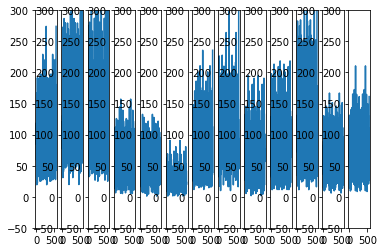

In [44]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=13, nrows=1)
plt.rcParams["figure.figsize"] = (20, 3)
for n in range(0, 13):
    npreds = training_rainfall[:, n]
    axs[n].plot(np.arange(0, npreds.shape[0], 1), npreds)
    axs[n].set_ylim([-50, 300])

In [32]:
def apply_augmentation(raw_rain, raw_vids):
    vids = np.copy(raw_vids)
    vids = vids + np.random.normal(0, 0.05, vids.shape)
    return np.concatenate((raw_vids, vids), axis=0), np.concatenate((raw_rain, raw_rain), axis=0)

APPLY_AUGMENTATION = True

if APPLY_AUGMENTATION:
    training_videos, training_rainfall = apply_augmentation(training_rainfall, training_videos)

In [33]:
training_videos.shape

(548, 28, 61, 121, 2)

### 1.1 DEPRECATED

This following section uses two separate datasets. Which is not required.

In [34]:
#training_datafile = "E:/31-12-2020/prepared-data/middle_train.npy"
#validation_datafile = "E:/31-12-2020/prepared-data/middle_valid.npy"
#
#training_rainfallfile = "E:/31-12-2020/prepared-data/expected_train.npy"
#validation_rainfallfile = "E:/31-12-2020/prepared-data/expected_valid.npy"

In [35]:
#training_videos = np.load(training_datafile)
#validation_videos = np.load(validation_datafile)
#
#training_rainfall = np.load(training_rainfallfile)[:, 2:]
#validation_rainfall = np.load(validation_rainfallfile)[:, 2:]

In [36]:
# We need them in X, Y, COLOURS
#training_videos = np.swapaxes(training_videos, 1, 2)
#training_videos = np.swapaxes(training_videos, 2, 3)
#training_videos = np.swapaxes(training_videos, 3, 4)
#
#validation_videos = np.swapaxes(validation_videos, 1, 2)
#validation_videos = np.swapaxes(validation_videos, 2, 3)
#validation_videos = np.swapaxes(validation_videos, 3, 4)

In [37]:
# Scale the data
#training_videos[:, :, :, :, 0] = (training_videos[:, :, :, :, 0] - np.min(training_videos[:, :, :, :, 0])) / (np.max(training_videos[:, :, :, :, 0]) - np.min(training_videos[:, :, :, :, 0]))
#training_videos[:, :, :, :, 1] = (training_videos[:, :, :, :, 1] - np.min(training_videos[:, :, :, :, 1])) / (np.max(training_videos[:, :, :, :, 1]) - np.min(training_videos[:, :, :, :, 1]))

#validation_videos[:, :, :, :, 0] = (validation_videos[:, :, :, :, 0] - np.min(validation_videos[:, :, :, :, 0])) / (np.max(validation_videos[:, :, :, :, 0]) - np.min(validation_videos[:, :, :, :, 0]))
#validation_videos[:, :, :, :, 1] = (validation_videos[:, :, :, :, 1] - np.min(validation_videos[:, :, :, :, 1])) / (np.max(validation_videos[:, :, :, :, 1]) - np.min(validation_videos[:, :, :, :, 1]))

## 2. Model Definition

Next, a CNN model architecture is defined.

In [45]:
class SlowFusion(Model):
    
    def __init__(self):
        super(SlowFusion, self).__init__()
        
        # First level
        self._first_layers = [
            self._generate_conv_layer(16, (2, 2, 2), (7, 61, 121, 2)),
            self._generate_conv_layer(16, (2, 2, 2), (7, 61, 121, 2)),
            self._generate_conv_layer(16, (2, 2, 2), (7, 61, 121, 2)),
            self._generate_conv_layer(16, (2, 2, 2), (7, 61, 121, 2))
        ]
        
        # Second level
        self._second_layers = [
            self._generate_conv_layer(16, (2, 2, 2), (6, 30, 60, 16)),
            self._generate_conv_layer(16, (2, 2, 2), (6, 30, 60, 16))
        ]
        
        # Third level
        self._third_layers = [
            self._generate_conv_layer(16, (2, 2, 2), (4, 14, 29, 16))
        ]
        

        # Final Dense layer
        self._final_layer = self._generate_dense_layer(13)
    
    def call(self, inputs):
        
        outputs = self._layer_one(inputs)
        #print(outputs[0].shape)
        outputs = self._layer_two(outputs)
        #print(outputs[0].shape)
        outputs = self._layer_three(outputs)
        #print(outputs.shape)
        outputs = self._final_layer(outputs)
        #print(outputs.shape)
        return outputs
        
    def _layer_one(self, inputs):
        outputs = []
        for n in range(0, 4):
            outputs.append(
                self._first_layers[n](
                    inputs[:, (n*7):((n+1)*7), :, :, :]
                )
            )
        trans_outputs = [
            tf.concat((outputs[0], outputs[1]), axis=1),
            tf.concat((outputs[2], outputs[3]), axis=1)
        ]
        return trans_outputs
    
    def _layer_two(self, inputs):
        outputs = []
        for n in range(0, 2):
            outputs.append(self._second_layers[n](inputs[n]))
        trans_outputs = [
            tf.concat((outputs[0], outputs[1]), axis=1)
        ]
        #trans_outputs = tf.concat((outputs[0], outputs[1]), axis=1)
        return trans_outputs
    
    def _layer_three(self, inputs):
        return self._third_layers[0](inputs)
    
    def _generate_conv_layer(self, filters, poolsize, input_shape):
        layer = Sequential()
        layer.add(Conv3D(
            filters, poolsize, input_shape=input_shape,
            kernel_initializer="glorot_normal"))#initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)))
        #layer.add(BatchNormalization())
        layer.add(Activation('relu'))
        layer.add(MaxPooling3D(pool_size=poolsize))
        return layer
    
    def _generate_dense_layer(self, output_size):
        layer = Sequential()
        layer.add(Flatten())
        layer.add(Dense(output_size, kernel_initializer="glorot_normal"))#initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)))
        #layer.add(BatchNormalization())
        layer.add(Activation('relu'))
        return layer

In [46]:
def model_generator(input_shape=(28, 61, 121, 2), learning_rate=0.1):
    """ This method generates a model definition. """
    model = SlowFusion()
    
    # Setup training mechanism
    model.compile(
        loss="mean_squared_error",
        optimizer=Adam(learning_rate=learning_rate))#SGD(lr=learning_rate, nesterov=True))
    
    return model

## 3. Model Training

Finally, training the model using the single framed data and opening a tensorboard instance with details.

In [47]:
def train_model(run_name, tensorboard, model, xdata, ydata, models_folder="D:/PHD_DATA/Video_18-01-2021/models/"):
    """ Trains the given model with the given dataset. """
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    #mc = ModelCheckpoint(
    #    filepath=models_folder + run_name,
    #    save_best_only=True,
    #    save_weights_only=False
    #)
    history = model.fit(
        xdata,
        ydata,
        batch_size=32,
        validation_split=0.3,
        callbacks=[tensorboard, es],
        epochs=25
    )
    save_model(model, models_folder + run_name + ".mdl")
    return history

In [48]:
# Flexible parameters
learning_rate = 0.01

In [49]:
# Run each model multiple times
for i in range(0, 5):
    run_name = "TEST-SF-99-{}".format(int(time.time()))#"SF_32_16_8__13__222_t-{}".format(int(time.time()))
    tb = TensorBoard(log_dir="D:/PHD_DATA/Video_18-01-2021/logs/{}".format(run_name))
    model = model_generator(learning_rate=learning_rate, input_shape=training_videos.shape[1:])
    history = train_model(run_name, tb, model, training_videos, training_rainfall)
    print("Final loss: {}".format(history.history["val_loss"][-1]))

Epoch 1/25
12/12 [==============================] - 82s 6s/step - loss: 7803.1365 - val_loss: 4310.2881
Epoch 2/25
12/12 [==============================] - 61s 5s/step - loss: 4318.0131 - val_loss: 4001.6504
Epoch 3/25
12/12 [==============================] - 59s 5s/step - loss: 4136.6382 - val_loss: 3958.6943
Epoch 4/25
12/12 [==============================] - 60s 5s/step - loss: 4021.5068 - val_loss: 3942.3408
Epoch 5/25
12/12 [==============================] - 59s 5s/step - loss: 4050.2675 - val_loss: 4091.4565
Epoch 6/25
12/12 [==============================] - 59s 5s/step - loss: 3942.6272 - val_loss: 3929.4041
Epoch 7/25
12/12 [==============================] - 59s 5s/step - loss: 4201.5889 - val_loss: 3973.5630
Epoch 8/25
12/12 [==============================] - 59s 5s/step - loss: 4139.6006 - val_loss: 3911.5029
Epoch 9/25
12/12 [==============================] - 60s 5s/step - loss: 4440.5414 - val_loss: 3922.5596
Epoch 10/25
12/12 [==============================] - 60s 5s/step

KeyboardInterrupt: 